## Baseline for Slot1

## Check dataset existence

In [1]:
# check data existence
from pathlib import Path


data_folder = Path.cwd().parent.joinpath("data/processed")

def check_data_existence(folder):
    file_count = len(list(folder.glob("e*_ann.json")))
    if  file_count == 0:
        raise Exception("Processed Data does not exist.")
    else:
        print("{} files exist.".format(file_count))


check_data_existence(data_folder)

230 files exist.


## Read Slot1 data to DataFrame

Basic strategy

* Predict the attribute from sentence. Because attribute keywords not


In [79]:
# Slot1 predicts E#A label from entity and sentence
import json
import pandas as pd
from collections import Counter
from janome.tokenizer import Tokenizer


dataset = []
word_freq = Counter()
word_freq_t = Counter()
tokenizer = Tokenizer(wakati=True)
WINDOW_SIZE = 3
PAD = "__PAD__"
UNK = "__UNK__"


def format_word(word):
    if word.isdigit():
        return "0"
    else:
        return word


def register_words(words, target=False):
    for w in words:
        if target:
            word_freq_t[w] += 1
        else:
            word_freq[format_word(w)] += 1

        
# convert 'from' 'to' to position on token
def convert_position(f, t, tokens):
    text = ""
    t_f = -1
    t_t = -1
    for i, x in enumerate(tokens):
        text += x
        if t_f < 0 and len(text) > f:
            t_f = i
        if t_f >= 0 and t_t < 0 and len(text) > t:
            t_t = i
            break

    return t_f, t_t
        

for f in data_folder.glob("e*_ann.json"):
    with f.open(encoding="utf-8") as j:
        d = json.load(j)        
        for s in d["sentences"]:
            # register words
            tokenized = tokenizer.tokenize(s["sentence"])
            register_words(tokenized)

            length = ""
            for o in s["opinions"]:
                targets = tokenizer.tokenize(o["target"])
                register_words(targets, target=True)

                # we need to convert position on str to position on word array
                f_t, t_t = convert_position(o["from"], o["to"], tokenized)
                
                # get context = before WINDOW_SIZE words + after WINDOW_SIZE words
                for t, p in zip(targets, range(f_t, t_t + 1)):
                    f_context = tokenized[max(0, p - WINDOW_SIZE) :p]
                    b_context = tokenized[(p + 1): (p  + 1 + WINDOW_SIZE)]
                    
                    f_context = ([PAD] * WINDOW_SIZE + f_context)[-WINDOW_SIZE:]
                    b_context = (b_context + [PAD] * WINDOW_SIZE)[:WINDOW_SIZE]
                    context = [format_word(x) for x in (f_context + b_context)]
                    
                    line = {
                        "label": o["category"],
                        "entity": o["category"].split("#")[0],
                        "target": t,
                        "context":  context
                    }
                    dataset.append(line)

In [80]:
%matplotlib inline

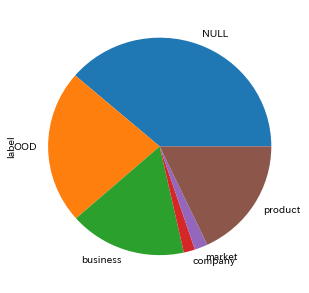

In [81]:
dataset = pd.DataFrame(dataset)
dataset.tail(5)
dataset.groupby("entity").count()["label"].plot.pie(figsize=(5, 5))

In [199]:
dataset.groupby("label").count()["target"].sort_values(ascending=False)

label
business#sales      1458
product#amount      1441
product#sales        975
product#general      677
business#profit      641
business#amount      391
business#general     369
market#general       338
company#sales         97
business#cost         85
company#amount        80
company#profit        61
product#price         54
business#price        54
company#general       40
product#profit        22
company#cost          11
product#cost          10
Name: target, dtype: int64

In [82]:
# Filter NULL / OOD entity
dataset = dataset[(dataset["entity"] != "NULL") & (dataset["entity"] != "OOD")]

In [135]:
# reset index from 0    
dataset.reset_index(drop=True, inplace=True)
# show dataset size
print("{} data is available.".format(len(dataset)))

6804 data is available.


In [136]:
dataset.head(5)

,context,entity,label,target
0,"[__PAD__, __PAD__, 当, 業界, におきまして, は]",market,market#general,歯科
1,"[__PAD__, 当, 歯科, におきまして, は, 、]",market,market#general,業界
2,"[分野, で, ある, 品, や, ＣＡＤ]",product,product#sales,化工
3,"[で, ある, 化工, や, ＣＡＤ, /]",product,product#sales,品
4,"[化工, 品, や, /, ＣＡＭ, 関連]",product,product#sales,ＣＡＤ


In [137]:
vocab = [PAD, UNK]
min_freq = 3

for term, freq in word_freq_t.most_common():
    vocab.append(term)
for term, freq in word_freq.most_common():
    if freq >= min_freq and term not in vocab:
        vocab.append(term)
        
print("Vocabulary size is {} (less than {} frequency word is excluded)".format(len(vocab), min_freq))

Vocabulary size is 4213 (less than 3 frequency word is excluded)


## Prepare the word vector

In [153]:
# check pretrained vector existence
EMBED_SIZE = 300  # fastText is 300dim
word_vector_path = Path.cwd().joinpath("wiki.ja.vec")
if not word_vector_path.exists():
    raise Exception("Pre-trained word vector is not downloaded. Please execute download_fast_text.py.")

In [139]:
import numpy as np


embedding_matrix = np.zeros((len(vocab), EMBED_SIZE)) 

hit_count = -1
with word_vector_path.open(encoding="utf-8") as f:
    for line in f:
        if hit_count == -1:
            hit_count = 0
            continue  # skip first line that has (vocab_size, vector_size)

        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        if word in vocab:
            hit_count += 1
            index = vocab.index(word)
            embedding_matrix[index] = vector

print("load word embeddings ({} / {} is loaded).".format(hit_count, len(vocab)))

load word embeddings (3601 / 4213 is loaded).


## Make Baseline Model

* Baseline Model predicts the label from concatenated vector of context & target.


In [154]:
labels = sorted(dataset.groupby("label").groups.keys())
print("Label count is {}.".format(len(labels)))

Label count is 18.


In [178]:
from keras.layers import Input
from keras import regularizers
from keras.layers.core import Activation, Dense, Flatten
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.utils import to_categorical


input_length = WINDOW_SIZE * 2 + 1
embedding_layer = Embedding(
                            len(vocab),
                            EMBED_SIZE,
                            input_length=input_length,
                            weights=[embedding_matrix])

inputs = Input(shape=(input_length, ))
vector = Flatten()(embedding_layer(inputs))
hidden = Dense(len(labels), kernel_regularizer=regularizers.l1())(vector)
outputs = Activation("softmax")(hidden)

model = Model(inputs=inputs, outputs=outputs)

In [176]:
X = np.zeros((len(dataset), input_length))
y = np.zeros(len(dataset))


def to_index(word):
    if word in vocab:
        return vocab.index(word)
    else:
        return vocab.index(UNK)


for index, row in dataset.iterrows():
    tokens = (row["context"] + [row["target"]])
    indicies = [to_index(t) for t in tokens]
    X[index] = indicies
    y[index] = labels.index(row["label"])

y = to_categorical(y, num_classes=len(labels))
print(X.shape)
print(y.shape)

(6804, 7)
(6804, 18)


## Train the Model

In [196]:
from keras_tqdm import TQDMNotebookCallback
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=['acc'])
model.fit(
    X_train, y_train, validation_data=(X_test, y_test), 
    batch_size=64, epochs=10, 
    verbose=0, callbacks=[TQDMNotebookCallback()])

HBox(children=(IntProgress(value=0, description='Training', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=4762), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 1', max=4762), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 2', max=4762), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 3', max=4762), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 4', max=4762), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 5', max=4762), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 6', max=4762), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 7', max=4762), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 8', max=4762), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 9', max=4762), HTML(value='')))

In [195]:
from sklearn.metrics import classification_report


y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred, target_names=labels))

                  precision    recall  f1-score   support

 business#amount       0.00      0.00      0.00       146
   business#cost       0.00      0.00      0.00        23
business#general       0.00      0.00      0.00       124
  business#price       0.00      0.00      0.00        19
 business#profit       0.00      0.00      0.00       202
  business#sales       0.52      0.03      0.06       407
  company#amount       0.00      0.00      0.00        25
    company#cost       0.00      0.00      0.00         3
 company#general       0.00      0.00      0.00        12
  company#profit       0.00      0.00      0.00        15
   company#sales       0.33      0.04      0.07        26
  market#general       0.05      1.00      0.10       103
  product#amount       0.00      0.00      0.00       433
    product#cost       0.00      0.00      0.00         1
 product#general       0.00      0.00      0.00       198
   product#price       0.00      0.00      0.00        15
  product#pro

/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
